In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import time
import xgboost as xgb
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
#from sklearn import pipeline, model_selection
from sklearn import pipeline, grid_search
#from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer

import re

import random
random.seed(2017)

pd.set_option("display.max_colwidth", 1000)

%matplotlib inline

import matplotlib

In [3]:
queries = pd.read_pickle('FEATURES_WITH_TEXT_1.data')

idx_train = pd.read_pickle('data/LABELS_TRAIN.df')
idx_test = pd.read_pickle('data/LABELS_TEST.df')

data = idx_train.join(queries)

In [7]:
aaa = data.loc[data.reset_index()['id'].sample(frac=0.7, random_state=149)]
bbb = data.loc[~data.index.isin(aaa.index)]

In [12]:
from collections import defaultdict
import math

def cc(n_,c_,s_):
    def ax(r):
        for w in r['query'].split():
            n_[w] += 1
            c_[w] += r['relevance']
            s_[w] += r['relevance']*r['relevance']
    return ax

n1 = defaultdict(lambda : 0)
c1 = defaultdict(lambda : 0)
s1 = defaultdict(lambda : 0)

_ = aaa.apply(cc(n1, c1, s1), axis=1)

n2 = defaultdict(lambda : 0)
c2 = defaultdict(lambda : 0)
s2 = defaultdict(lambda : 0)

_ = bbb.apply(cc(n2, c2, s2), axis=1)


cn1 = {}
cnd1 = {}
for w in c1:
    cn1[w] = c1[w]*1.0/n1[w]
    cnd1[w] = math.sqrt( max(0,(s1[w]*1.0/n1[w]) - (cn1[w]*cn1[w])))
    
words1 = sorted([ (cn1[te], cnd1[te], nu, te) for nu, te in sorted([ (v, k) for k,v in n1.items() if v > 20], reverse=True)])    

cn2 = {}
cnd2 = {}
for w in c2:
    cn2[w] = c2[w]*1.0/n2[w]
    cnd2[w] = math.sqrt( max(0,(s2[w]*1.0/n2[w]) - (cn2[w]*cn2[w])))
    
words2 = sorted([ (cn2[te], cnd2[te], nu, te) for nu, te in sorted([ (v, k) for k,v in n2.items() if v > 20], reverse=True)])    

list_words = [w[3] for w in words1 if ((w[2] < 2.30 and cn.get(w[3], 3) < 2.35) or (w[2] > 2.70 and cn2.get(w[3], 0) > 2.65))]

In [16]:
sum([np.array([1,3]), np.array([1,3])])

array([2, 6])

In [52]:
def word_feats(r):
    qs = r['query'].split()
    if len(qs) < 1:
        qs = ['__NOSUCHWORD']
    ss = pd.Series(sum([np.array([1.0 if w == q else 0.0 for w in list_words]) for q in qs]))
    return ss

In [53]:
special_word_matches = queries.apply(word_feats, axis=1)

In [54]:
special_word_matches.columns = ['word_%s' % w for w in list_words]

In [51]:
queries.loc[9913]

query                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [55]:
special_word_matches[special_word_matches.isnull()['word_nail']]

,word_mdf,word_stucco,word_clips,word_silicone,word_mailbox,word_nail,word_shutters,word_slip,word_humidifier,word_j,...,word_char,word_trimmers,word_prelit,word_oleum,word_broil,word_file,word_lutron,word_xenon,word_bistro,word_drivers
id,,,,,,,,,,,,,,,,,,,,,


In [56]:
np.save('SPECIAL_WORDS_FEAT_TRAIN', np.array(idx_train.join(special_word_matches).drop('relevance', axis=1)))
np.save('SPECIAL_WORDS_FEAT_TEST', np.array(idx_test.join(special_word_matches).drop('relevance', axis=1)))

In [33]:
#queries.join(special_word_matches)

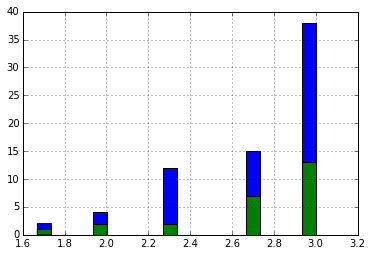

In [5]:
#'model', 'counter', 'frame', 'roof', 'high', 'electrical', 'parts', 'windows', 'concrete', 'l', 'home'
wordd = 'dispenser'

xx = aaa[
    (aaa['query'].apply(lambda s: wordd in s.split()))
    ]
xx['relevance'].hist(bins=20)

yy = bbb[
    (bbb['query'].apply(lambda s: wordd in s.split()))
    ]
yy['relevance'].hist(bins=20)

In [4]:
queries

,query,product_uid,product_title,product_description,brand,attrs,brand_none,brand_unbranded,brand_hampton,brand_kohler,...,c34,c35,c36,c37,c38,c39,c40,c41,c42,c43
id,,,,,,,,,,,,,,,,,,,,,
1,90 unitsdegrees bracket,100001,simpson strong tie strongtie 12 gauge angle,only angles make joints stronger they also provide more consistent straight corners simpson strong tie strongtie offers wide variety angles various sizes thicknesses handle light duty lightduty jobs projects where structural connection needed bent skewed match project outdoor projects those where moisture present use our zmax zinc coate coated zinccoate zinccoated connectors provide extra resistance against corrosion look z end model number versatile connector various 90 connections home repair projects stronger than angled nailing screw fastening alone help ensure joints consistently straight strong dimensions 3 unitsinches xby 3 unitsinches xby 1 1d2 unitsinches made 12 gauge steel galvanized extra corrosion resistance install 10 d common nails 9 xby 1 1d2 unitsinches strong drive strongdrive sd screws,simpson strong tie strongtie,product width 3 bullet 02 stronger than angled nailing screw fastening alone bullet 01 versatile connector various 90 connections home repair projects bullet 06 galvanized extra corrosion resistance bullet 03 help ensure joints consistently straight strong material galvanized steel bullet 05 made 12 gauge steel number pieces 1 bullet 07 install 10 d common nails 9 xby 1 1d2 unitsinches strong drive strongdrive sd screws bullet 04 dimensions 3 unitsinches xby 3 unitsinches xby 1 1d2 unitsinches product height 3 gauge 12 mfg brand name simpson strong tie strongtie product depth 1p5 product weight lb 0p26,0.0,0.0,0.0,0.0,...,0,0,0,0.000000,0,0,0,15,0,0
2,angle bracket,100001,simpson strong tie strongtie 12 gauge angle,only angles make joints stronger they also provide more consistent straight corners simpson strong tie strongtie offers wide variety angles various sizes thicknesses handle light duty lightduty jobs projects where structural connection needed bent skewed match project outdoor projects those where moisture present use our zmax zinc coate coated zinccoate zinccoated connectors provide extra resistance against corrosion look z end model number versatile connector various 90 connections home repair projects stronger than angled nailing screw fastening alone help ensure joints consistently straight strong dimensions 3 unitsinches xby 3 unitsinches xby 1 1d2 unitsinches made 12 gauge steel galvanized extra corrosion resistance install 10 d common nails 9 xby 1 1d2 unitsinches strong drive strongdrive sd screws,simpson strong tie strongtie,product width 3 bullet 02 stronger than angled nailing screw fastening alone bullet 01 versatile connector various 90 connections home repair projects bullet 06 galvanized extra corrosion resistance bullet 03 help ensure joints consistently straight strong material galvanized steel bullet 05 made 12 gauge steel number pieces 1 bullet 07 install 10 d common nails 9 xby 1 1d2 unitsinches strong drive strongdrive sd screws bullet 04 dimensions 3 unitsinches xby 3 unitsinches xby 1 1d2 unitsinches product height 3 gauge 12 mfg brand name simpson strong tie strongtie product depth 1p5 product weight lb 0p26,0.0,0.0,0.0,0.0,...,0,0,0,0.000000,0,0,0,15,0,0
3,l bracket,100001,simpson strong tie strongtie 12 gauge angle,only angles make joints stronger they also provide more consistent straight corners simpson strong tie strongtie offers wide variety angles various sizes thicknesses handle light duty lightduty jobs projects where structural connection needed bent skewed match project outdoor projects those where moisture present use our zmax zinc coate coated zinccoate zinccoated connectors provide extra resistance against corrosion look z end model number versatile connector various 90 connections home repair projects stronger than angled nailing screw fastening alone help ensure joints consistently straight